## Exploratory Data Analysis

Этот ноутбук выполнялся на локалке и данные были скачаны в репозиторий, но лучше их доставать из гугл хранилища по [ссылке](https://drive.google.com/drive/folders/1v0oiDUUlZqhvtloymUYT5LmMeSqzrNEP). Папка ml_crash_course, data_sg - сингапур, data_se - стокгольм

In [24]:
PATH = 'C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data/'

#### Load Libraries

In [4]:
# pip install pandarallel

In [121]:
# pip install translate

In [122]:
import os
import glob

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=16)

from IPython.display import clear_output
from translate import Translator

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [5]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

#### Load Data

In [6]:
# # Для Google Colab подключения к гугл диску
# collab_env = True
# if collab_env:
#     from google.colab import drive

#     ROOT_DIR = '/content/drive'
#     RANDOM_SEED = 42
#     drive.mount(ROOT_DIR)
#     DRIVE_DATA_DIR = 'ml_crash_course'
#     root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
# else:
#     # in the case of local file systen
#     root_data_dir = '/srv/data/'

# clear_output()
# data_version = '2023_08_06'
# print()
# print("Content in root_data_dir %s:\n%s" % (root_data_dir, [i for i in os.listdir(root_data_dir)]))

In [7]:
# для гугл колаб
# !ls /content/drive/MyDrive/ml_crash_course/data_sg

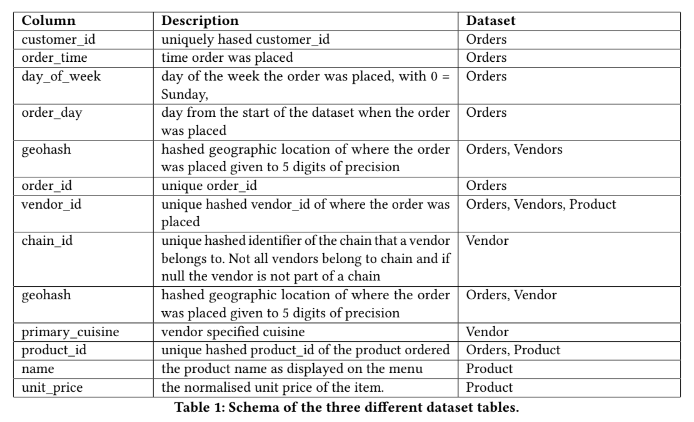

#### Descriptive DA

In [38]:
def dda(file_name):
    if ('train' in file_name)  or ('test' in file_name):
        pass
    else:
        ds = pd.read_csv(os.path.join(PATH, 'data_sg', file_name))

        print(color.BOLD + color.GREEN + f'\n-------------------- DDA of {file_name} dataset -----------------------\n' + color.END)

        print(f'The given dataset of {file_name} contains {ds.shape[0]} rows and {ds.shape[1]} columns.\n')

        print('Showing ds info\n')
        display(ds.info())
        print('\n')

        try:
            assert all(ds['Unnamed: 0'] == ds.index)
            ds = ds.drop(ds.columns[0], axis=1)
        except AssertionError:
            print(f'\nThere is df index and column "Unnamed: 0" mismatch in {file_name}')
            display(ds[ds['Unnamed: 0'] != ds.index])
            ds = ds.set_index('Unnamed: 0', drop=False)
            assert all(ds['Unnamed: 0'] == ds.index)
            ds = ds.drop(ds.columns[0], axis=1)

        for col in ds.columns:
            if col in ['customer_id', 'vendor_id', 'product_id', 'chain_id']:
                ds[col] = ds[col].astype(str)
            elif col == 'order_id':
                ds[col] = ds[col].astype(int)

        print('Showing a sum of NaN values by column\n')
        display(ds.isna().sum())
        print('\n')

        numerical_data = ds.select_dtypes(include='number')
        numerical_features=numerical_data.columns.tolist()
        print(f'There are {len(numerical_features)} numerical features in {file_name}:')
        print(numerical_features)

        categorical_data=ds.select_dtypes(include='object')
        categorical_features=categorical_data.columns.tolist()
        print(f'There are {len(categorical_features)} categorical features in {file_name}:')
        print(categorical_features, '\n')

        if len(numerical_features) != 0:
            print(color.BOLD + color.PURPLE + '\n----------- Numerical Features Analysis -----------\n' + color.END)
            print('Showing descriptive stats of numerical columns\n')
            display(numerical_data.describe().T)
            print('\n')

            print('Showing variance of numerical columns\n')
            display(numerical_data.var())
            print('\n')

            print('Showing skew of numerical columns\n')
            display(numerical_data.skew())
            print('\n')

            print('Showing number of unique values in each of numerical features\n')
            display(numerical_data.nunique())
            print('\n')

            print('Showing dist histograms of numerical features\n')
            numerical_data.hist(figsize=(14, 6), bins=20)
            plt.show()


        if len(categorical_features) != 0:
            print(color.BOLD + color.BLUE + '\n----------- Categorical Features Analysis -----------\n' + color.END)
            print('Showing descriptive stats of categorical columns\n')
            display(categorical_data.describe(include='object').T)
            print('\n')

            unique_counts=categorical_data.nunique()
            for index, i in enumerate(range(len(unique_counts))):
                print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
                if unique_counts[i] < 100:
                    print()
                    print(f"\033[1m{categorical_features[i]}\033[0m\n")
                    plt.figure(figsize=(18, 6))
                    categorical_data[categorical_features[i]].value_counts().sort_index().plot(kind='bar', rot=90, xlabel=categorical_features[i], ylabel='count')
                    plt.show()

        ds.to_pickle(f'{file_name.split(".")[0]}')


In [39]:
# для гугл колаб
# os.chdir('/content/drive/MyDrive/ml_crash_course/data_sg')


-------------------- DDA of C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\orders_sg.txt dataset -----------------------

The given dataset of C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\orders_sg.txt contains 4023005 rows and 9 columns.

Showing ds info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4023005 entries, 0 to 4023004
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Unnamed: 0   int64 
 1   customer_id  object
 2   geohash      object
 3   order_id     int64 
 4   vendor_id    object
 5   product_id   object
 6   day_of_week  int64 
 7   order_time   object
 8   order_day    object
dtypes: int64(3), object(6)
memory usage: 276.2+ MB


None



Showing a sum of NaN values by column



customer_id    0
geohash        0
order_id       0
vendor_id      0
product_id     0
day_of_week    0
order_time     0
order_day      0
dtype: int64



There are 2 numerical features in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\orders_sg.txt:
['order_id', 'day_of_week']
There are 6 categorical features in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\orders_sg.txt:
['customer_id', 'geohash', 'vendor_id', 'product_id', 'order_time', 'order_day'] 


----------- Numerical Features Analysis -----------

Showing descriptive stats of numerical columns



,count,mean,std,min,25%,50%,75%,max
order_id,4023005.0,994522.623503,580784.271794,0.0,490439.0,986525.0,1500777.0,1999999.0
day_of_week,4023005.0,3.229277,2.014137,0.0,1.0,3.0,5.0,6.0




Showing variance of numerical columns



order_id       3.373104e+11
day_of_week    4.056749e+00
dtype: float64



Showing skew of numerical columns



order_id       0.020994
day_of_week   -0.143856
dtype: float64



Showing number of unique values in each of numerical features



order_id       2000000
day_of_week          7
dtype: int64



Showing dist histograms of numerical features



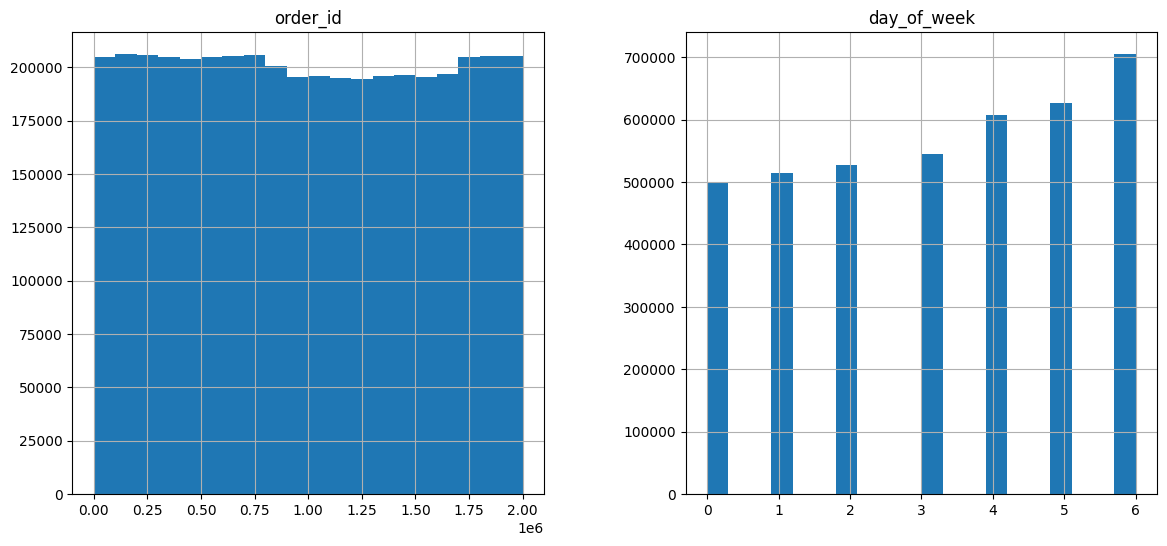


----------- Categorical Features Analysis -----------

Showing descriptive stats of categorical columns



,count,unique,top,freq
customer_id,4023005,512916,50acf8536f,691
geohash,4023005,45,w21z6,420840
vendor_id,4023005,7411,709e5409,6704
product_id,4023005,256502,ecc84756562d,803
order_time,4023005,82013,12:11:34,206
order_day,4023005,91,28 days,63454


C:\Users\User\AppData\Local\Temp\ipykernel_18712\493488232.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_18712\493488232.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


0 customer_id has 512916 unique values
1 geohash has 45 unique values

geohash



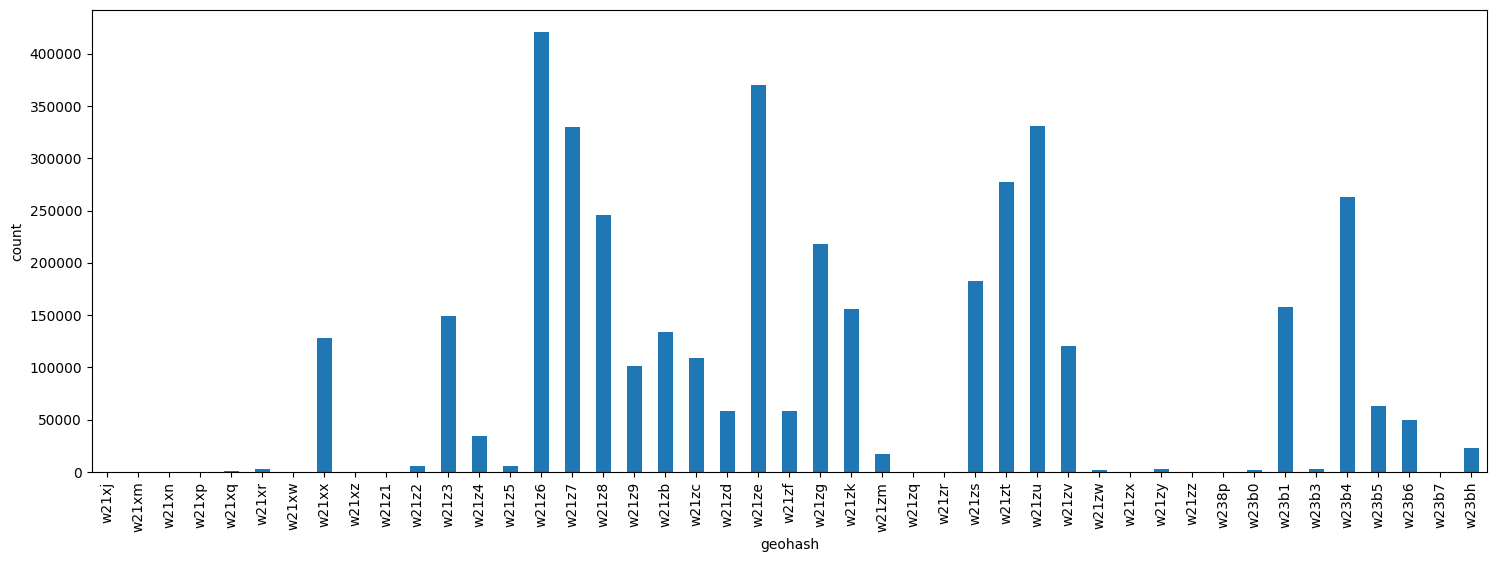

C:\Users\User\AppData\Local\Temp\ipykernel_18712\493488232.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_18712\493488232.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


2 vendor_id has 7411 unique values
3 product_id has 256502 unique values
4 order_time has 82013 unique values
5 order_day has 91 unique values

order_day



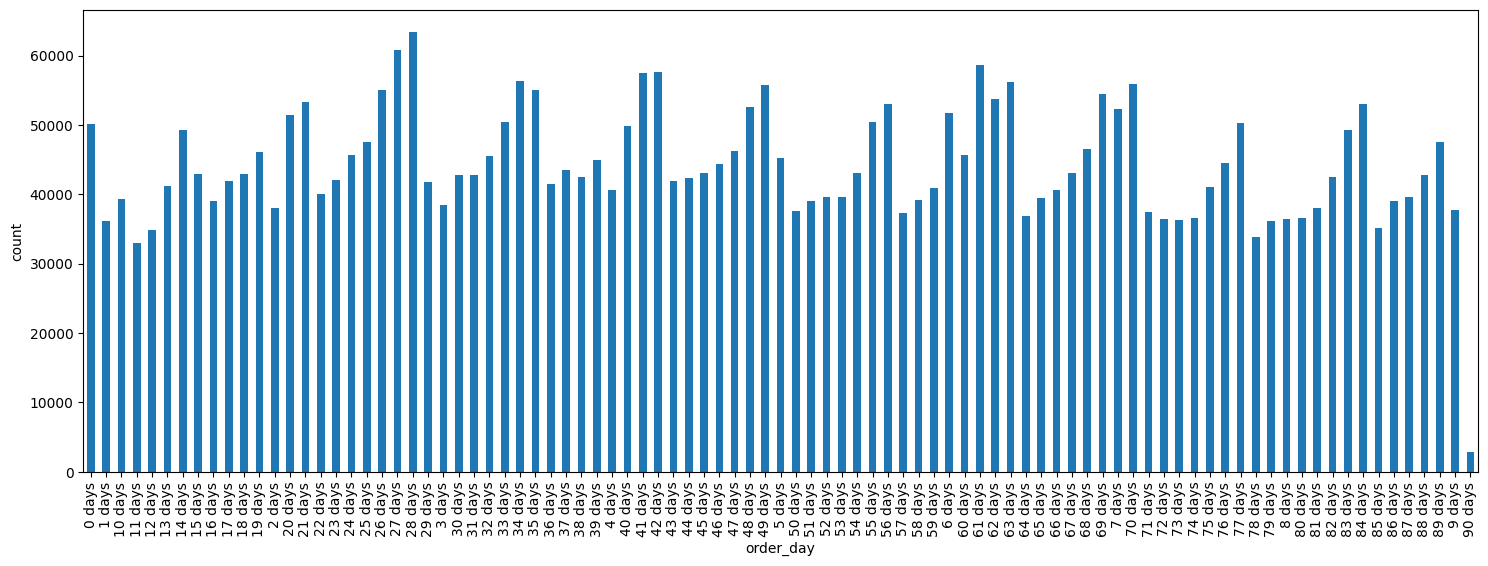


-------------------- DDA of C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\products_sg.txt dataset -----------------------

The given dataset of C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\products_sg.txt contains 1066840 rows and 5 columns.

Showing ds info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066840 entries, 0 to 1066839
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1066840 non-null  int64  
 1   vendor_id   1066840 non-null  object 
 2   product_id  1066840 non-null  object 
 3   name        1066800 non-null  object 
 4   unit_price  1066840 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 40.7+ MB


None



Showing a sum of NaN values by column



vendor_id      0
product_id     0
name          40
unit_price     0
dtype: int64



There are 1 numerical features in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\products_sg.txt:
['unit_price']
There are 3 categorical features in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\products_sg.txt:
['vendor_id', 'product_id', 'name'] 


----------- Numerical Features Analysis -----------

Showing descriptive stats of numerical columns



,count,mean,std,min,25%,50%,75%,max
unit_price,1066840.0,0.003751,0.008651,0.0,0.0,0.0024,0.0044,1.0




Showing variance of numerical columns



unit_price    0.000075
dtype: float64



Showing skew of numerical columns



unit_price    31.933794
dtype: float64



Showing number of unique values in each of numerical features



unit_price    446
dtype: int64



Showing dist histograms of numerical features



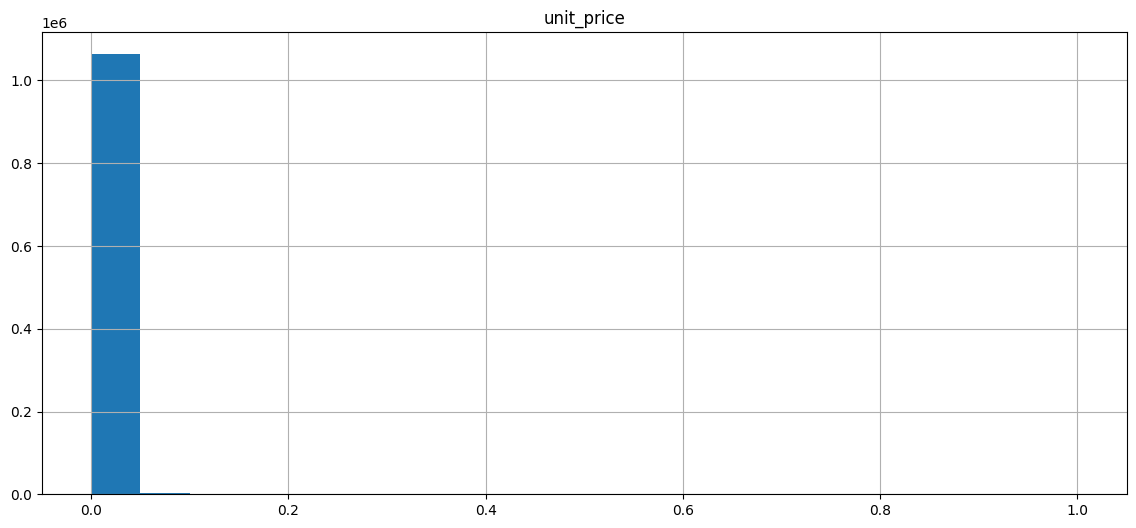


----------- Categorical Features Analysis -----------

Showing descriptive stats of categorical columns



,count,unique,top,freq
vendor_id,1066840,7411,7bf10d94,1254
product_id,1066840,1066823,f96cd0f8cb41,2
name,1066800,274914,Coke,1685


C:\Users\User\AppData\Local\Temp\ipykernel_18712\493488232.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_18712\493488232.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


0 vendor_id has 7411 unique values
1 product_id has 1066823 unique values
2 name has 274914 unique values

-------------------- DDA of C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\vendors_sg.txt dataset -----------------------

The given dataset of C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\vendors_sg.txt contains 7411 rows and 5 columns.

Showing ds info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7411 entries, 0 to 7410
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       7411 non-null   int64 
 1   vendor_id        7411 non-null   object
 2   chain_id         5912 non-null   object
 3   geohash          7411 non-null   object
 4   primary_cuisine  7411 non-null   object
dtypes: int64(1), object(4)
memory usage: 289.6+ KB


None




There is df index and column "Unnamed: 0" mismatch in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\vendors_sg.txt


,Unnamed: 0,vendor_id,chain_id,geohash,primary_cuisine
2,4,03eb25e1,5055ab25,w21ze,bak kut teh
3,5,3613129a,8984acb6,w23b1,italian
4,7,0946c9e5,1e3a2913,w21z4,bak kut teh
5,13,89188652,NaN,w21z7,laksa
6,16,e05cc628,NaN,w21z3,tea
...,...,...,...,...,...
7406,17798,2d0b2dfb,1a3564c8,w21zt,mala xiang guo
7407,17799,15bbf316,434020fb,w21zs,mala xiang guo
7408,17801,a1f11221,b5431702,w21zu,mala xiang guo
7409,17803,6268886c,0f494195,w21z8,mala xiang guo


Showing a sum of NaN values by column



vendor_id          0
chain_id           0
geohash            0
primary_cuisine    0
dtype: int64



There are 0 numerical features in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\vendors_sg.txt:
[]
There are 4 categorical features in C:/Users/User/Desktop/Repos/RecSys_ShopCartPred/data\vendors_sg.txt:
['vendor_id', 'chain_id', 'geohash', 'primary_cuisine'] 


----------- Categorical Features Analysis -----------

Showing descriptive stats of categorical columns



,count,unique,top,freq
vendor_id,7411,7411,b160c319,1
chain_id,7411,1855,nan,1499
geohash,7411,31,w21z7,1309
primary_cuisine,7411,78,chinese,770




0 vendor_id has 7411 unique values
1 chain_id has 1855 unique values
2 geohash has 31 unique values

geohash



C:\Users\User\AppData\Local\Temp\ipykernel_18712\493488232.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_18712\493488232.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


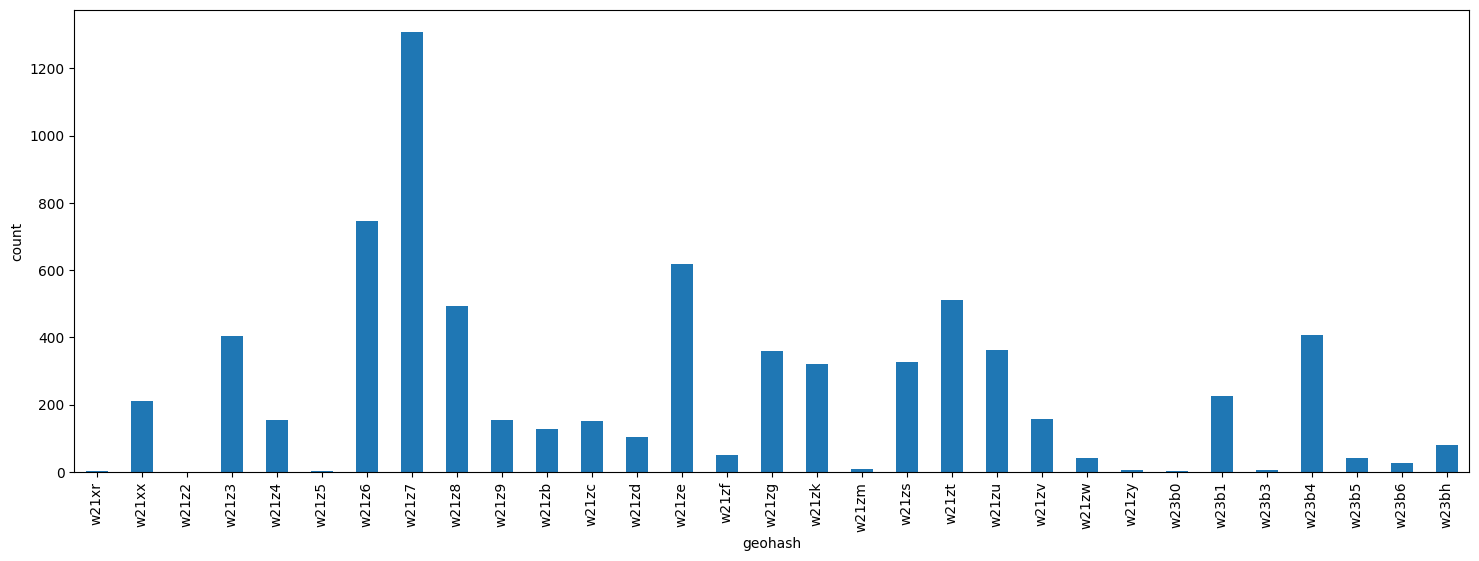

C:\Users\User\AppData\Local\Temp\ipykernel_18712\493488232.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(index, f'{categorical_features[i]} has {unique_counts[i]} unique values')
C:\Users\User\AppData\Local\Temp\ipykernel_18712\493488232.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique_counts[i] < 100:


3 primary_cuisine has 78 unique values

primary_cuisine



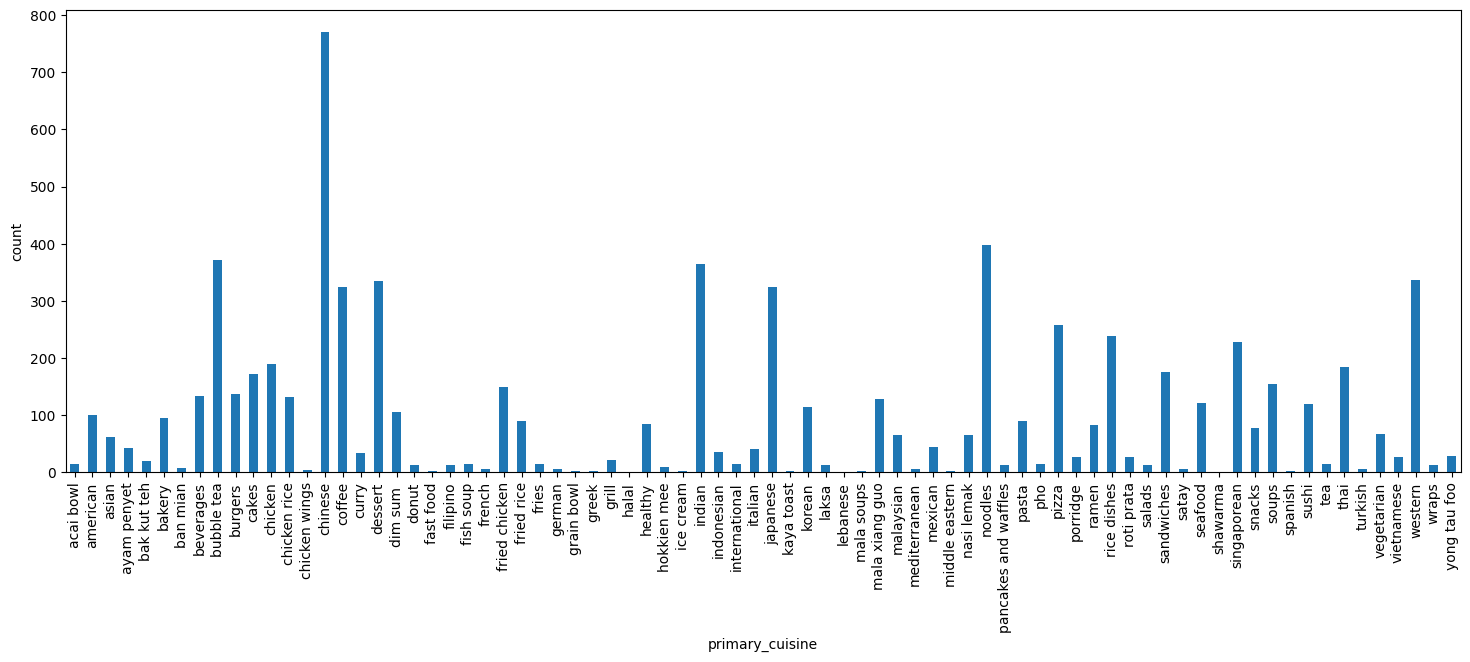

In [40]:
for i in [i for i in glob.glob(PATH + '*.{}'.format('txt'))]:
    dda(i)

**Замечания**

Нормализованная **unit_price** имеет крайне длинный правый хвост (коэф смещения == 31.933794) - значит большинство цен низкие, но есть несколько товаров, цена которых лежит на верзней границе диапазона. возможно, их придется выкинуть из анализа


### Check ids, uniqueness, duplicates, data types, data shapes etc.

In [42]:
orders_sg = pd.read_pickle('data/orders_sg')
products_sg = pd.read_pickle('data/products_sg')
vendors_sg = pd.read_pickle('data/vendors_sg')

In [243]:
orders_sg['order_time'] = orders_sg['order_time'].astype(str)
orders_sg['order_day'] = orders_sg['order_day'].astype(str)

In [43]:
orders_sg[[col for col in orders_sg.columns if 'id' in col]]

,customer_id,order_id,vendor_id,product_id
0,1ba124d4e5,0,212753d2,783e85338f1c
1,1ba124d4e5,0,212753d2,084ab73246e6
2,1ba124d4e5,0,212753d2,30eba3cc2676
3,1ba124d4e5,0,212753d2,3910309eea60
4,1ba124d4e5,0,212753d2,20049fb602cb
...,...,...,...,...
4023000,7e3554a009,1999998,ff0edd9f,7602ccd87eea
4023001,7e3554a009,1999998,ff0edd9f,91129b65ae92
4023002,7e3554a009,1999999,2bba6450,7bb67a5dd524
4023003,7e3554a009,1999999,2bba6450,d40fe2db522c


In [44]:
products_sg[[col for col in products_sg.columns if 'id' in col]]

,vendor_id,product_id
0,15bbf316,59099e089514
1,e7b24dc0,52e1017fdbd9
2,e7b24dc0,fcb7110cd932
3,7112a20b,d3e7708c2bc9
4,6137ef21,bf0d5ac0e03c
...,...,...
1066835,3a3422b7,74792a33ac62
1066836,1ee69614,c782aedb62ae
1066837,67499b6a,59537c172b6a
1066838,f444f459,c999a7a4b2f5


In [45]:
vendors_sg[[col for col in vendors_sg.columns if 'id' in col]]

,vendor_id,chain_id
Unnamed: 0,,
0,b160c319,d2786168
1,9c8f010e,d2786168
4,03eb25e1,5055ab25
5,3613129a,8984acb6
7,0946c9e5,1e3a2913
...,...,...
17798,2d0b2dfb,1a3564c8
17799,15bbf316,434020fb
17801,a1f11221,b5431702


In [46]:
orders_sg.dtypes

customer_id    object
geohash        object
order_id        int32
vendor_id      object
product_id     object
day_of_week     int64
order_time     object
order_day      object
dtype: object

In [47]:
products_sg.dtypes

vendor_id      object
product_id     object
name           object
unit_price    float64
dtype: object

In [48]:
vendors_sg.dtypes

vendor_id          object
chain_id           object
geohash            object
primary_cuisine    object
dtype: object

In [49]:
orders_sg.nunique()

customer_id     512916
geohash             45
order_id       2000000
vendor_id         7411
product_id      256502
day_of_week          7
order_time       82013
order_day           91
dtype: int64

In [50]:
products_sg.nunique()

vendor_id        7411
product_id    1066823
name           274914
unit_price        446
dtype: int64

In [51]:
vendors_sg.nunique()

vendor_id          7411
chain_id           1855
geohash              31
primary_cuisine      78
dtype: int64

In [79]:
orders_sg.geohash = orders_sg.geohash.astype(str)

In [80]:
# orders_sg[['customer_id', 'vendor_id', 'product_id']] = orders_sg[['customer_id', 'vendor_id', 'product_id']].astype(str)
# orders_sg['order_id'] = orders_sg['order_id'].astype(int)

# products_sg[['vendor_id', 'product_id']] = products_sg[['vendor_id', 'product_id']].astype(str)
# vendors_sg[['vendor_id', 'chain_id']] = vendors_sg[['vendor_id', 'chain_id']].astype(str)

In [81]:
orders_sg['order_day_int'] = orders_sg['order_day'].parallel_apply(lambda x: int(x.replace(' days', '')))

#### Проверка соответствия продуктов

In [52]:
f'Видим, что всего в датасете продуктов есть {products_sg.product_id.nunique()} уникальных айтема, тогда как в заказах есть всего {orders_sg.product_id.nunique()} товара, что **составляет {orders_sg.product_id.nunique()/products_sg.product_id.nunique() * 100 :.3f}%**'

'Видим, что всего в датасете продуктов есть 1066823 уникальных айтема, тогда как в заказах есть всего 256502 товара, что **составляет 24.044%**'

Видим, что всего в датасете продуктов есть 1066823 уникальных айтема, тогда как в заказах есть всего 256502 товара, что **составляет 24.044%** от всего множества продуктов.

In [242]:
orders_sg

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,order_day_int
0,1ba124d4e5,w21z7,0,212753d2,783e85338f1c,0,12:03:29,85 days,85
1,1ba124d4e5,w21z7,0,212753d2,084ab73246e6,0,12:03:29,85 days,85
2,1ba124d4e5,w21z7,0,212753d2,30eba3cc2676,0,12:03:29,85 days,85
3,1ba124d4e5,w21z7,0,212753d2,3910309eea60,0,12:03:29,85 days,85
4,1ba124d4e5,w21z7,0,212753d2,20049fb602cb,0,12:03:29,85 days,85
...,...,...,...,...,...,...,...,...,...
4023000,7e3554a009,w21zt,1999998,ff0edd9f,7602ccd87eea,5,22:09:10,55 days,55
4023001,7e3554a009,w21zt,1999998,ff0edd9f,91129b65ae92,5,22:09:10,55 days,55
4023002,7e3554a009,w21zt,1999999,2bba6450,7bb67a5dd524,5,19:57:51,62 days,62
4023003,7e3554a009,w21zt,1999999,2bba6450,d40fe2db522c,5,19:57:51,62 days,62


In [83]:
print(orders_sg.shape, products_sg.shape)

(4023005, 9) (1066840, 4)


In [84]:
merged = orders_sg.merge(products_sg, on=['product_id', 'vendor_id'], how='left')

In [86]:
merged.shape

(4023005, 11)

In [87]:
merged.isna().sum()

customer_id       0
geohash           0
order_id          0
vendor_id         0
product_id        0
day_of_week       0
order_time        0
order_day         0
order_day_int     0
name             49
unit_price       49
dtype: int64

In [88]:
merged.nunique()

customer_id       512916
geohash               45
order_id         2000000
vendor_id           7411
product_id        256502
day_of_week            7
order_time         82013
order_day             91
order_day_int         91
name               99586
unit_price           185
dtype: int64

In [75]:
merged[merged.unit_price.isna()].vendor_id.unique()

array(['a06f1cbf'], dtype=object)

In [89]:
merged[merged.unit_price.isna()].product_id.unique()

array(['1cc4fc0888d2', '5639066e786a', 'e65f47a39650', '6acee6cf16ca',
       '3cfc6048b8eb', '06f435509b10'], dtype=object)

In [90]:
products_sg[products_sg.product_id.isin(merged[merged.unit_price.isna()].product_id)]

,vendor_id,product_id,name,unit_price
213384,4cf81fe1,6acee6cf16ca,I16. Mixed Ingredients Crispy Noodles 什锦滑蛋生面,0.0024
258777,4cf81fe1,3cfc6048b8eb,I15. Mee Goreng 海鲜马来炒面,0.0024
294543,4cf81fe1,e65f47a39650,I13. KL Dai Lok Mee K L 大碌面,0.0028
306263,4cf81fe1,5639066e786a,I14. KL White Loh Mee K L 白卤面,0.0028
431639,4cf81fe1,1cc4fc0888d2,I17. Salted Fish Fried Rice 咸鱼炒饭,0.0024
444594,4cf81fe1,06f435509b10,I18. Fried Dry Hor Fun 干炒河,0.0024


In [91]:
products_sg[products_sg.vendor_id.isin(merged[merged.unit_price.isna()].vendor_id) \
            & products_sg.product_id.isin(merged[merged.unit_price.isna()].product_id)]

,vendor_id,product_id,name,unit_price


Видим, что с продуктами в целом нет ничего подозрительного, просто датасет продуктов сожержит большее количество продуктов чем продавалось в рассматриваемый период, однако важно заметить что продукты '1cc4fc0888d2', '5639066e786a', 'e65f47a39650', '6acee6cf16ca', '3cfc6048b8eb', '06f435509b10' продаваемые вендором 'a06f1cbf' есть в датасете продаж, но их нет в датасете продуктов

Возможно у них просто сменился вендор, либо это ошибка.

In [98]:
# чисто ради интереса посчитаем среднее количество заказов од одного покупателя за эти 90 дней
merged.order_id.nunique() / merged.customer_id.nunique()

3.899273955189544

In [105]:
products_sg

,vendor_id,product_id,name,unit_price
0,15bbf316,59099e089514,Meat & Seafood Combo 海鲜套餐,0.0036
1,e7b24dc0,52e1017fdbd9,Sausage Egg McMuffin® Meal,0.0024
2,e7b24dc0,fcb7110cd932,Scrambled Egg Burger w Chicken Meal,0.0024
3,7112a20b,d3e7708c2bc9,Maguro Sushi,0.0012
4,6137ef21,bf0d5ac0e03c,Family Meal - Prosp Chic TwLEVMx2 + ChBurgerHM,0.0100
...,...,...,...,...
1066835,3a3422b7,74792a33ac62,西兰花 Broccoli\t,0.0012
1066836,1ee69614,c782aedb62ae,Gula Melaka Sago 椰糖西米露,0.0012
1066837,67499b6a,59537c172b6a,Double Egg Prata,0.0012
1066838,f444f459,c999a7a4b2f5,Sprite,0.0012


In [109]:
products_sg.duplicated(['product_id']).sum()

17

17 дублей по id

In [110]:
products_sg[products_sg.duplicated(['product_id'], keep=False)].sort_values('product_id')

,vendor_id,product_id,name,unit_price
841968,4cf81fe1,032690175d82,I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭,0.0028
392653,a06f1cbf,032690175d82,I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭,0.0028
715087,c19e57fb,06cbeac1e258,Teriyaki Chicken Burger with French Fries Meal,0.0036
919194,987da7cb,06cbeac1e258,Teriyaki Chicken Burger with French Fries Meal,0.0036
713906,4cf81fe1,0e1f455b56a9,I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭,0.0028
606997,a06f1cbf,0e1f455b56a9,I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭,0.0028
236011,4cf81fe1,2c87c973b870,I10. Salted Egg Diced Chicken with Rice 咸蛋鸡丁饭,0.0028
608240,a06f1cbf,2c87c973b870,I10. Salted Egg Diced Chicken with Rice 咸蛋鸡丁饭,0.0032
819256,a06f1cbf,2f9ddb3f502c,I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭,0.0028
842537,4cf81fe1,2f9ddb3f502c,I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭,0.0028


In [106]:
products_sg.duplicated(['vendor_id', 'product_id']).sum()

0

Нет абсолютных дубликатов в продуктах по айди и вендору, что хорошо

In [107]:
products_sg.duplicated(['name', 'product_id']).sum()

15

In [108]:
products_sg[products_sg.duplicated(['name', 'product_id'], keep=False)].sort_values('product_id')

,vendor_id,product_id,name,unit_price
392653,a06f1cbf,032690175d82,I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭,0.0028
841968,4cf81fe1,032690175d82,I12. Sweet & Sour Sliced Fish with Rice 酸甜生鱼片饭,0.0028
919194,987da7cb,06cbeac1e258,Teriyaki Chicken Burger with French Fries Meal,0.0036
715087,c19e57fb,06cbeac1e258,Teriyaki Chicken Burger with French Fries Meal,0.0036
606997,a06f1cbf,0e1f455b56a9,I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭,0.0028
713906,4cf81fe1,0e1f455b56a9,I05. Salted Egg Pork Ribs with Rice 咸蛋排骨饭,0.0028
236011,4cf81fe1,2c87c973b870,I10. Salted Egg Diced Chicken with Rice 咸蛋鸡丁饭,0.0028
608240,a06f1cbf,2c87c973b870,I10. Salted Egg Diced Chicken with Rice 咸蛋鸡丁饭,0.0032
842537,4cf81fe1,2f9ddb3f502c,I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭,0.0028
819256,a06f1cbf,2f9ddb3f502c,I02. Dry Curry Sliced Pork with Rice 干咖喱猪肉饭,0.0028


Кажется немного странным что у разных вендоров в датасете есть абсолютно идентичные товары по названию и цене, нужна доп информация

15 дублей по имени и айди, проверим сначала где еще 2 которые дубли просто по айди

In [111]:
set(products_sg[products_sg.duplicated(['product_id'], keep=False)].name) - set(products_sg[products_sg.duplicated(['name', 'product_id'], keep=False)].name)

{'Haagen Dazs Mini-Tub',
 'Haagen Dazs Mini-Tub ',
 'I04. Jing Du Pork Ribs with Rice 京都排骨王饭',
 'I04. Kyoto Pork Ribs With Rice 京都排骨王饭'}

В 1 продукте есть опечатка в виде доп пробела, это поправим чтобы не было доп товаров

Во 2 продукте есть различие в названии несмотря на то что они вроде бы одинаковые

In [115]:
products_sg.loc[products_sg.name == 'Haagen Dazs Mini-Tub ', 'name']  = 'Haagen Dazs Mini-Tub'

In [119]:
products_sg.loc[products_sg.name == 'I04. Jing Du Pork Ribs with Rice 京都排骨王饭']

,vendor_id,product_id,name,unit_price
204539,4cf81fe1,5f9cfe69e1db,I04. Jing Du Pork Ribs with Rice 京都排骨王饭,0.0028
416581,7bcc735a,14a828fd7ca5,I04. Jing Du Pork Ribs with Rice 京都排骨王饭,0.0028


In [118]:
products_sg.loc[products_sg.name == 'I04. Kyoto Pork Ribs With Rice 京都排骨王饭']

,vendor_id,product_id,name,unit_price
392374,a06f1cbf,5f9cfe69e1db,I04. Kyoto Pork Ribs With Rice 京都排骨王饭,0.0028
393391,7bcc735a,db9ea30b4a0f,I04. Kyoto Pork Ribs With Rice 京都排骨王饭,0.0028


In [126]:
translator = Translator(from_lang="zh", to_lang='en')
print(
    translator.translate("京都排骨王饭"),
    '\n',
    translator.translate("京都排骨王饭")
)

Kyoto King Rice with Pork Ribs 
 Kyoto King Rice with Pork Ribs


Интересная ситуация, похожая на ошибку

Из этих 4х 
- товары с одинаковым названием имеют разные айди
- товары с одинаковыми айди 5f9cfe69e1db имеют разные названия
- все товары имеют одинаковую цену
- товары имеют идентичную форму записи и одинаковый конец названия на китайском

Логично переименовать Jing Du в Kyoto, так как перевод говорит что там есть слово Китот и чтобы один и тот же товар не рекомендовался как разные 

С другой стороны если это сделать то у одного вендора будут продукты с одинаковым названием но разными айди, и у разных вендоров будет товар с одним и тем же айди и названием. Второе мы уже встречали в этих данных, оставим, а для первой проблемы -  проверим есть ли этот товар в заказах и просто кикнем этот товар

In [127]:
orders_sg[orders_sg.product_id.isin(['db9ea30b4a0f', '5f9cfe69e1db', '14a828fd7ca5'])]

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,order_day_int
33599,8a4d6dfcb3,w21zt,16379,a06f1cbf,5f9cfe69e1db,6,20:10:11,56 days,56
596073,3ddfc03ef2,w21zt,290150,a06f1cbf,5f9cfe69e1db,5,20:42:28,34 days,34
728250,baaa90a060,w21zt,354648,a06f1cbf,5f9cfe69e1db,5,17:31:05,48 days,48
961776,115a5fba9c,w21zt,468672,a06f1cbf,5f9cfe69e1db,0,19:24:34,22 days,22
1397761,0442917069,w21zt,681717,a06f1cbf,5f9cfe69e1db,0,20:00:54,50 days,50
1437172,2ad0374431,w21zt,700675,a06f1cbf,5f9cfe69e1db,3,13:35:07,4 days,4
1437173,2ad0374431,w21zt,700676,a06f1cbf,5f9cfe69e1db,6,20:26:27,0 days,0
1962742,f2a1265bd4,w21zv,961582,a06f1cbf,5f9cfe69e1db,4,19:33:44,26 days,26
1962745,f2a1265bd4,w21zv,961582,a06f1cbf,5f9cfe69e1db,4,19:33:44,26 days,26
2603189,f63289b389,w21zt,1289523,a06f1cbf,5f9cfe69e1db,1,18:31:07,44 days,44


Этот товар есть в продажах только под одним айди 5f9cfe69e1db и только от одного вендора a06f1cbf

In [128]:
products_sg[products_sg.product_id.isin(['db9ea30b4a0f', '5f9cfe69e1db', '14a828fd7ca5'])]

,vendor_id,product_id,name,unit_price
204539,4cf81fe1,5f9cfe69e1db,I04. Jing Du Pork Ribs with Rice 京都排骨王饭,0.0028
392374,a06f1cbf,5f9cfe69e1db,I04. Kyoto Pork Ribs With Rice 京都排骨王饭,0.0028
393391,7bcc735a,db9ea30b4a0f,I04. Kyoto Pork Ribs With Rice 京都排骨王饭,0.0028
416581,7bcc735a,14a828fd7ca5,I04. Jing Du Pork Ribs with Rice 京都排骨王饭,0.0028


In [129]:
products_sg.shape

(1066840, 4)

In [132]:
products_sg.loc[products_sg.name == 'I04. Jing Du Pork Ribs with Rice 京都排骨王饭', 'name'] = 'I04. Kyoto Pork Ribs With Rice 京都排骨王饭'

products_sg = products_sg.drop(products_sg[products_sg.product_id.isin(['db9ea30b4a0f', '14a828fd7ca5'])].index, axis=0)

#### Duplicates and Groups

In [133]:
orders_sg.duplicated(['order_id']).sum()

2023005

In [137]:
orders_sg.duplicated(['order_id', 'geohash']).sum()

2023005

In [134]:
orders_sg[orders_sg.duplicated(['order_id'])]

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,order_day_int
1,1ba124d4e5,w21z7,0,212753d2,084ab73246e6,0,12:03:29,85 days,85
2,1ba124d4e5,w21z7,0,212753d2,30eba3cc2676,0,12:03:29,85 days,85
3,1ba124d4e5,w21z7,0,212753d2,3910309eea60,0,12:03:29,85 days,85
4,1ba124d4e5,w21z7,0,212753d2,20049fb602cb,0,12:03:29,85 days,85
6,f374c8c54c,w21zt,1,21830106,146127be77d4,4,19:03:03,61 days,61
...,...,...,...,...,...,...,...,...,...
4022998,4caee817ab,w21zt,1999997,81960769,3707116ae849,6,10:27:34,28 days,28
4022999,4caee817ab,w21zt,1999997,81960769,e418a2a168d8,6,10:27:34,28 days,28
4023001,7e3554a009,w21zt,1999998,ff0edd9f,91129b65ae92,5,22:09:10,55 days,55
4023003,7e3554a009,w21zt,1999999,2bba6450,d40fe2db522c,5,19:57:51,62 days,62


##### Делаем датасет сгруппированных заказов

In [95]:
%%time
# agg_func_count = {'product_id': ['count', 'nunique', 'size']}
# agg_func_text = {'vendor_id': ['count', 'nunique', set], 'product_id': ['count', 'nunique', set], 'order_day': [set], 'day_of_week': [set], 'geohash': [set]}
# group = orders_sg.groupby('order_id').agg(agg_func_text)
# group.to_pickle('groupped_orders')

CPU times: total: 7min 38s
Wall time: 7min 44s


In [ ]:
group = pd.read_pickle('groupped_orders')

In [135]:
group

vendor_id                     product_id          \
             count nunique         set      count nunique   
order_id                                                    
0                5       1  {212753d2}          5       5   
1                8       1  {21830106}          8       8   
2                4       1  {ee4f2ee0}          4       4   
3                3       1  {b62d39b7}          3       3   
4                4       1  {e33ad7ec}          4       4   
...            ...     ...         ...        ...     ...   
1999995          1       1  {2dbc05bb}          1       1   
1999996          2       1  {43bd9cf3}          2       2   
1999997          3       1  {81960769}          3       3   
1999998          2       1  {ff0edd9f}          2       2   
1999999          3       1  {2bba6450}          3       3   

                                                             order_day  \
                                                        set        set   
order_id                                                                 
0         {084ab73246e6, 783e85338f1c, 3910309eea60, 200...  {85 days}   
1         {da422c7836e1, 6c108c0fb2b9, adf53ab3befe, 146...  {61 days}   
2         {2c349859aa69, b47b2a83502a, a3e4aac0520d, 4e1...   {8 days}   
3                {60a5baff060c, d732733afc92, ad485fc36ebe}  {59 days}   
4         {cbe8ace5c352, 5bb2e3772724, ff6a45fa52e6, bc5...  {81 days}   
...                                                     ...        ...   
1999995                                      {cad0a6aa5b51}  {32 days}   
1999996                        {142ad3401af3, 6b36ca15e1f6}   {4 days}   
1999997          {75ff2fb5b5ef, e418a2a168d8, 3707116ae849}  {28 days}   
1999998                        {91129b65ae92, 7602ccd87eea}  {55 days}   
1999999          {7bb67a5dd524, 5925157ecb14, d40fe2db522c}  {62 days}   

         day_of_week  geohash  
                 set      set  
order_id                       
0                {0}  {w21z7}  
1                {4}  {w21zt}  
2                {0}  {w21z6}  
3                {2}  {w21z6}  
4                {3}  {w21z6}  
...              ...      ...  
1999995          {3}  {w21zt}  
1999996          {3}  {w21zt}  
1999997          {6}  {w21zt}  
1999998          {5}  {w21zt}  
1999999          {5}  {w21zt}  

[2000000 rows x 9 columns]

In [99]:
# проверяем что нет дублей, что каждому заказу соответствует один день и геохэш
# аггрегация по продуктам позволяет посмотреть состав каждого заказа
assert all(group[group['order_day', 'set'].str.len() == 1])
assert all(group[group['day_of_week', 'set'].str.len() == 1])
assert all(group[group['geohash', 'set'].str.len() == 1])
# вендоров  может быть несколько на один заказ, но у нас везде один
assert all(group[group['vendor_id', 'nunique'] == 1])
# интересно что ни в одном заказе не заказано два одинаковых товара
assert all(group[group['product_id', 'nunique'] == group['product_id', 'count']])

In [100]:
groupped_orders = group[[('vendor_id', 'set'), ('product_id', 'set'), ('order_day', 'set'), ('day_of_week', 'set'), ('geohash', 'set')]].copy(deep=True)
groupped_orders.columns = groupped_orders.columns.droplevel(-1)

In [101]:
# de-set data
groupped_orders[['vendor_id','order_day', 'day_of_week', 'geohash']] = groupped_orders[['vendor_id','order_day', 'day_of_week', 'geohash']].explode(['vendor_id','order_day', 'day_of_week', 'geohash'])

In [102]:
groupped_orders['product_id'] = groupped_orders['product_id'].parallel_apply(lambda x: list(x))

In [139]:
groupped_orders = groupped_orders.reset_index()

In [140]:
# groupped_orders.to_pickle('groupped_orders_proc')

In [141]:
groupped_orders

,order_id,vendor_id,product_id,order_day,day_of_week,geohash
0,0,212753d2,"[30eba3cc2676, 084ab73246e6, 20049fb602cb, 783...",85 days,0,w21z7
1,1,21830106,"[da422c7836e1, 64a268be5f2e, adf53ab3befe, 6c1...",61 days,4,w21zt
2,2,ee4f2ee0,"[a3e4aac0520d, 4e1d649b81a5, 2c349859aa69, b47...",8 days,0,w21z6
3,3,b62d39b7,"[ad485fc36ebe, d732733afc92, 60a5baff060c]",59 days,2,w21z6
4,4,e33ad7ec,"[ff6a45fa52e6, cbe8ace5c352, bc5f3e4a7234, 5bb...",81 days,3,w21z6
...,...,...,...,...,...,...
1999995,1999995,2dbc05bb,[cad0a6aa5b51],32 days,3,w21zt
1999996,1999996,43bd9cf3,"[142ad3401af3, 6b36ca15e1f6]",4 days,3,w21zt
1999997,1999997,81960769,"[3707116ae849, e418a2a168d8, 75ff2fb5b5ef]",28 days,6,w21zt
1999998,1999998,ff0edd9f,"[7602ccd87eea, 91129b65ae92]",55 days,5,w21zt


In [143]:
groupped_orders.duplicated(['order_id']).sum()

0

In [142]:
groupped_orders.duplicated(['order_id', 'geohash']).sum()

0

С заказами все ок.

##### Проверка вендоров

In [155]:
vendors_sg.vendor_id.nunique()

7411

In [156]:
products_sg.vendor_id.nunique()

7411

In [157]:
orders_sg.vendor_id.nunique()

7411

In [187]:
set(orders_sg.vendor_id) == set(vendors_sg.vendor_id) == set(products_sg.vendor_id)

True

Все вендоры из датасета вендоров представлены в заказах

In [36]:
vendors_sg

,vendor_id,chain_id,geohash,primary_cuisine
Unnamed: 0,,,,
0,b160c319,d2786168,w21z6,mexican
1,9c8f010e,d2786168,w21ze,mexican
4,03eb25e1,5055ab25,w21ze,bak kut teh
5,3613129a,8984acb6,w23b1,italian
7,0946c9e5,1e3a2913,w21z4,bak kut teh
...,...,...,...,...
17798,2d0b2dfb,1a3564c8,w21zt,mala xiang guo
17799,15bbf316,434020fb,w21zs,mala xiang guo
17801,a1f11221,b5431702,w21zu,mala xiang guo


In [37]:
vendors_sg.duplicated(['vendor_id']).sum()

0

In [144]:
vendors_sg.duplicated(['vendor_id', 'geohash']).sum()

0

Интересно, что означает хэш в датасете с вендорами?

In [147]:
len(set(vendors_sg.geohash))

31

In [148]:
len(set(orders_sg.geohash))

45

In [149]:
len(set(vendors_sg.geohash) & set(orders_sg.geohash))

31

In [150]:
set(vendors_sg.geohash) - set(orders_sg.geohash)

set()

In [151]:
set(orders_sg.geohash) - set(vendors_sg.geohash) 

{'w21xj',
 'w21xm',
 'w21xn',
 'w21xp',
 'w21xq',
 'w21xw',
 'w21xz',
 'w21z1',
 'w21zq',
 'w21zr',
 'w21zx',
 'w21zz',
 'w238p',
 'w23b7'}

Множество геохэшей датасета вендоров является подмножеством множества геохэшей датасета продаж

In [165]:
vendors_sg[['geohash', 'vendor_id']].value_counts(dropna=False)

geohash  vendor_id
w21xr    4cf81fe1     1
w21zk    2b992a15     1
         29e1b765     1
         28f5bafd     1
         28a35710     1
                     ..
w21z7    ba373d26     1
         ba2329fa     1
         ba15b5c2     1
         b9de26c6     1
w23bh    fe4cf855     1
Name: count, Length: 7411, dtype: int64

In [184]:
vendors_sg[['vendor_id', 'geohash']].value_counts(dropna=False)

vendor_id  geohash
0002b34d   w21z7      1
ab8515ed   w21z7      1
ab83658c   w21z6      1
ab7e0073   w21z7      1
ab795cb2   w21zs      1
                     ..
57882626   w21z7      1
5776a60b   w21ze      1
576fd131   w21z8      1
57696131   w21z3      1
fffdb009   w21z7      1
Name: count, Length: 7411, dtype: int64

In [186]:
orders_sg.geohash.nunique()

45

In [164]:
groupped_orders[['vendor_id', 'geohash']].value_counts(dropna=False)

vendor_id  geohash
fd18f1b9   w21zt      646
44c11977   w21zt      645
c6fc2d91   w21zc      644
74563548   w21ze      642
85627833   w21zv      640
                     ... 
9b7f6a6d   w21zw        1
           w21zm        1
           w21xx        1
9b54c880   w23bh        1
829f9bf3   w21zt        1
Name: count, Length: 25234, dtype: int64

In [188]:
# orders_sg.groupby(['vendor_id', 'order_id',]).agg('count')

In [171]:
orders_sg.shape

(4023005, 9)

In [172]:
check.shape

(4023005, 3)

In [170]:
check = orders_sg[['vendor_id', 'geohash']].merge(vendors_sg[['vendor_id', 'geohash']], on='vendor_id', how='left')
check[check.geohash_x != check.geohash_y]

,vendor_id,geohash_x,geohash_y
13,ee4f2ee0,w21z6,w21z7
14,ee4f2ee0,w21z6,w21z7
15,ee4f2ee0,w21z6,w21z7
16,ee4f2ee0,w21z6,w21z7
17,b62d39b7,w21z6,w21z3
...,...,...,...
4023000,ff0edd9f,w21zt,w21zv
4023001,ff0edd9f,w21zt,w21zv
4023002,2bba6450,w21zt,w21zv
4023003,2bba6450,w21zt,w21zv


1. интересно что у каждого заказа есть только 1 вендор
2. но для каждого вендора в заказах есть несколько разных геохэшей

какой же выбран геохэш для вендора в датасете вендоров - не ясно :( рандомный из датасета заказов видимо?

## Histograms

#### Prices

посмотрим еще дополнительно на цены

In [189]:
products_sg[products_sg.unit_price == 0].shape

(294542, 4)

In [191]:
products_sg[products_sg.unit_price == 0].product_id.nunique()

294542

In [194]:
orders_sg[orders_sg.product_id.isin(products_sg[products_sg.unit_price == 0].product_id.unique())].shape

(40462, 9)

In [196]:
orders_sg.shape

(4023005, 9)

In [197]:
orders_sg_cut = orders_sg[~orders_sg.product_id.isin(products_sg[products_sg.unit_price == 0].product_id.unique())]

In [198]:
orders_sg_cut.shape

(3982543, 9)

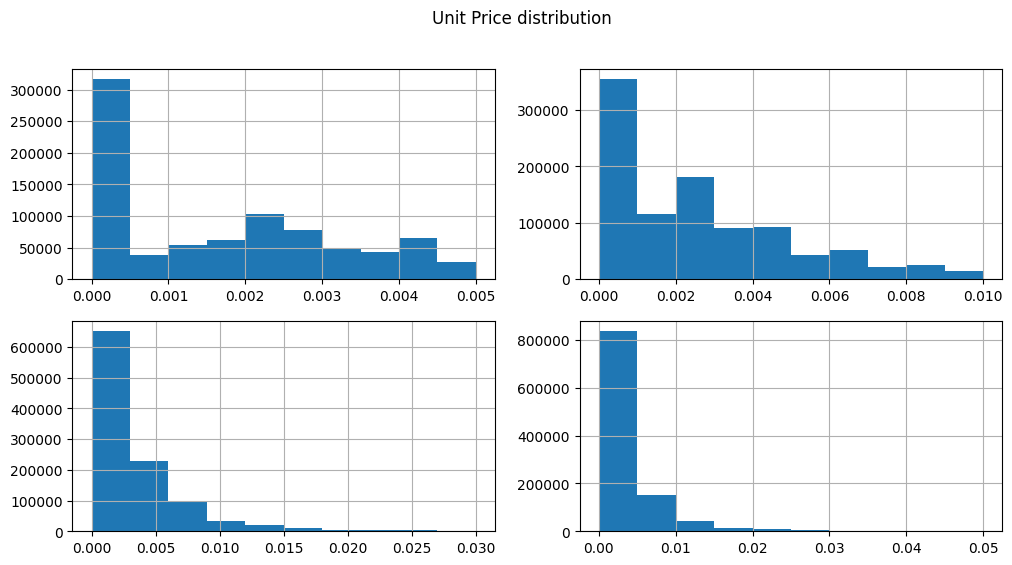

In [20]:
plt.figure(figsize=(12, 6))
plt.suptitle('Unit Price distribution')

plt.subplot(221)
products_sg.unit_price.hist(range=(0, 0.005))

plt.subplot(222)
products_sg.unit_price.hist(range=(0, 0.01))

plt.subplot(223)
products_sg.unit_price.hist(range=(0, 0.03))

plt.subplot(224)
products_sg.unit_price.hist(range=(0, 0.05))

plt.show()

агрегируем и посмотрим на распределение времени заказа

In [216]:
products_sg.shape

(1066838, 4)

In [230]:
products_sg[products_sg.unit_price > 0.02]

,vendor_id,product_id,name,unit_price
29,3c1d4c4f,a102e5175176,Re Focus Hard,0.0516
30,3c1d4c4f,a2f31ddc1d30,Re Wind Soft,0.0468
85,2f2bcb7c,d30bdb10ff22,Galaxy Durian MSW - 7 Inch,0.0356
127,c84ac95c,ace052fe45fa,BBQ Set A,0.0276
128,c84ac95c,69d226a6bd39,BBQ Set B,0.0276
...,...,...,...,...
962021,f349812f,4a641f0ef2ea,Twinpack Quart - 2 x Quart,0.0216
962047,e89fb82f,86f6db5264c2,Full,0.0220
962059,af827e5c,04c16331f695,Jumbo Prawn & Rosu Katsu Set,0.0236
962070,d6333098,b04fbe8974ab,Pork Belly Chashu (Frozen),0.0208


In [241]:
products_sg[(products_sg.unit_price != 0) & (products_sg.unit_price < 0.01)].shape

(693725, 4)

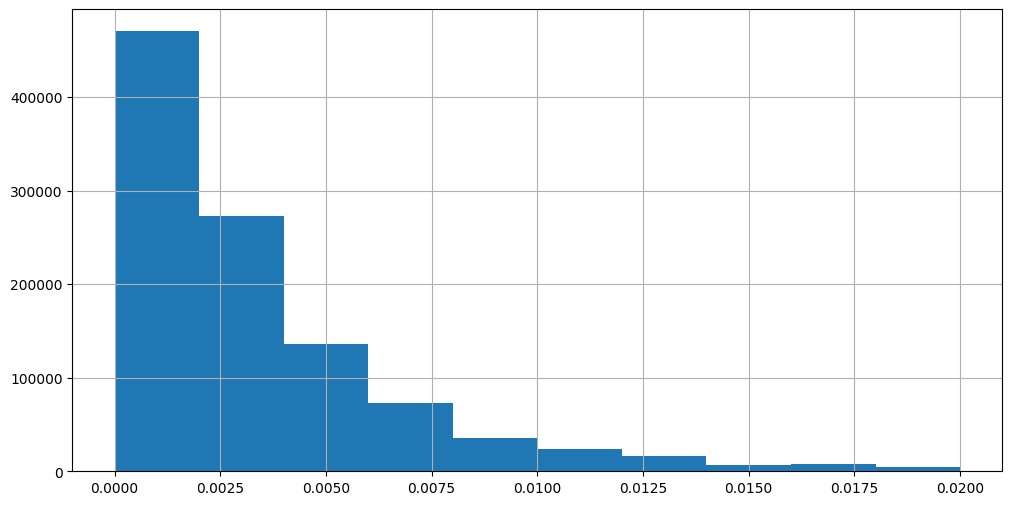

In [234]:
plt.figure(figsize=(12, 6))

products_sg.unit_price.hist(range=(0, 0.02))
plt.show()

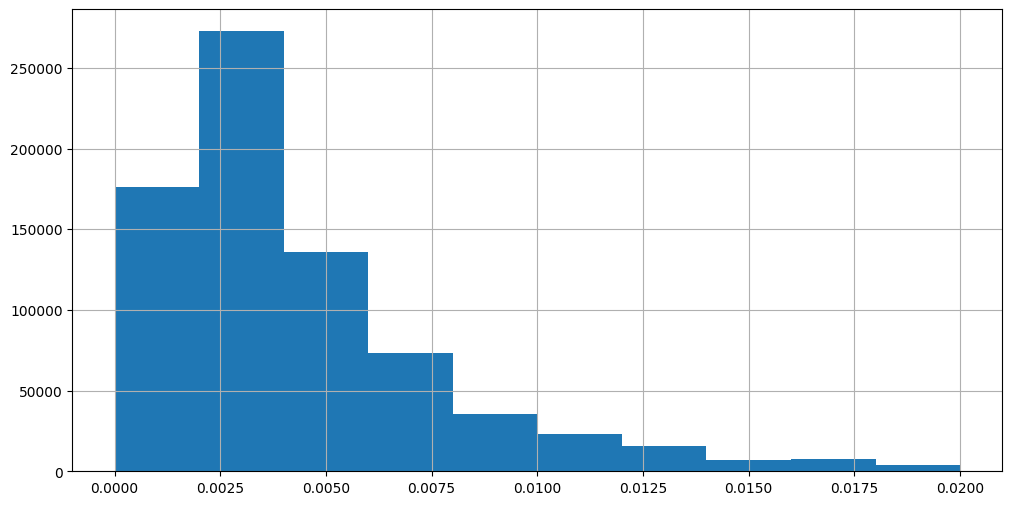

In [235]:
plt.figure(figsize=(12, 6))

products_sg[products_sg.unit_price != 0].unit_price.hist(range=(0, 0.02))
plt.show()

Во-первых нам не нужны продукты с ценой 0
Во-вторых нужно хоть немного укоротить хвост распределения и выкинуть продукты с ценой больше 0.02

In [244]:
orders_sg_cut['order_hour'] = orders_sg_cut['order_time'].parallel_apply(lambda x: int(x.split(':')[0]))

C:\Users\User\AppData\Local\Temp\ipykernel_18712\1052680767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_sg_cut['order_hour'] = orders_sg_cut['order_time'].parallel_apply(lambda x: int(x.split(':')[0]))


<Axes: xlabel='order_hour'>

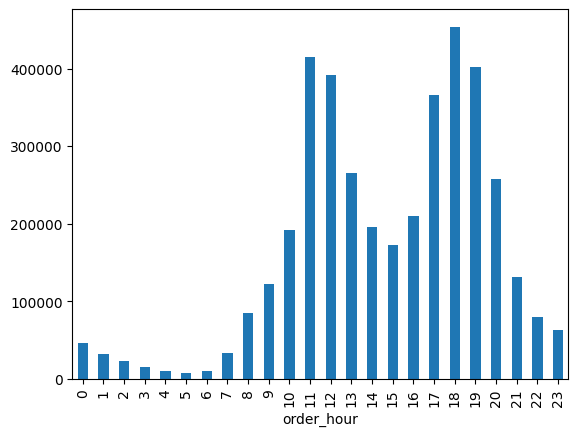

In [245]:
orders_sg_cut['order_hour'].value_counts().loc[[0, 1, 2, 3,
                                            4, 5, 6, 7,
                                            8, 9, 10, 11,
                                            12, 13, 14, 15,
                                            16, 17, 18, 19,
                                            20, 21, 22, 23]].plot.bar()

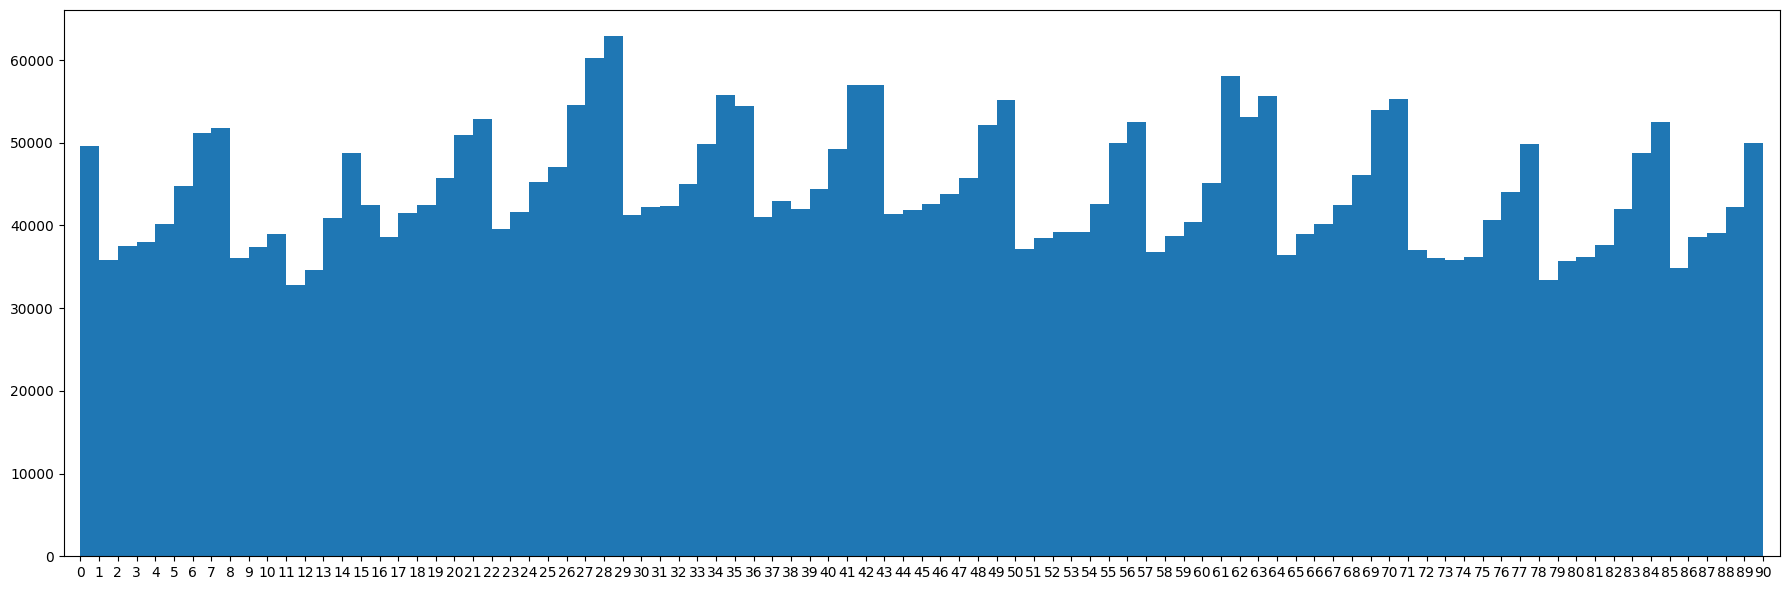

In [246]:
# orders_sg['order_day_int'].value_counts().plot.bar()
plt.figure(figsize=(18, 6))
plt.hist(orders_sg_cut['order_day_int'], bins=90)
plt.xticks(orders_sg_cut['order_day_int'].unique())
plt.tight_layout()
plt.margins(x=0.01)
plt.show();

Возьмем последние 50 дней чтобы использовать более актуальные заказы

<Axes: >

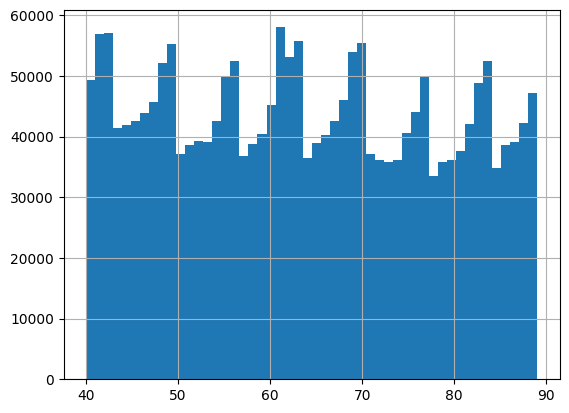

In [268]:
orders_sg_cut[(orders_sg_cut.order_day_int > 39) & (orders_sg_cut.order_day_int < 90)]['order_day_int'].hist(bins=50)

<Axes: >

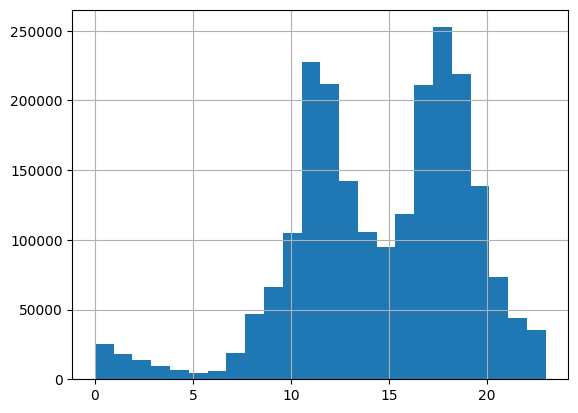

In [269]:
orders_sg_cut[(orders_sg_cut.order_day_int > 39) & (orders_sg_cut.order_day_int < 90)]['order_hour'].hist(bins=24)

<Axes: >

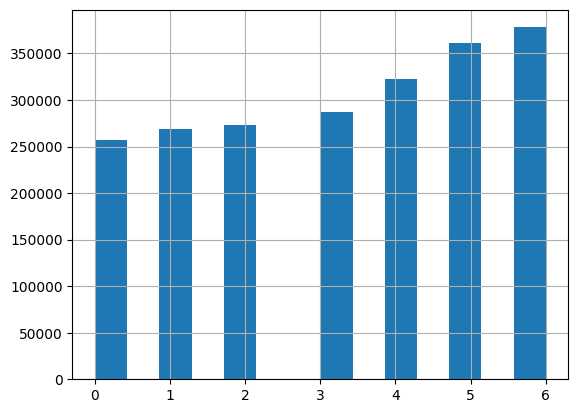

In [270]:
orders_sg_cut[orders_sg_cut.order_day_int > 40]['day_of_week'].hist(bins=14)

In [247]:
# def make_date(ds):
#   # print(ds['order_day'])
#   return pd.to_datetime(
#     str(pd.to_datetime('03/06/2023', format='%d/%m/%Y') + pd.to_timedelta(ds['order_day']))[:10] + ' ' + ds['order_time'],
#     format='%Y-%m-%d %H:%M:%S')

# orders_sg['order_time_dt'] = orders_sg[['order_day', 'order_time']].parallel_apply(make_date, axis=1)

In [249]:
# orders_sg['order_time_dt'] =
# pd.Timestamp.today().date() - pd.to_timedelta('92 days')

# datetime.datetime.now().date()  - pd.to_timedelta('55 days')

In [248]:
# orders_sg['order_time_dt'] = pd.to_datetime(orders_sg.order_time, format='%H:%M:%S').dt.time

## Correlation Analysis

In [282]:
from sklearn.preprocessing import LabelEncoder

In [271]:
orders_sg_cut.columns

Index(['customer_id', 'geohash', 'order_id', 'vendor_id', 'product_id',
       'day_of_week', 'order_time', 'order_day', 'order_day_int',
       'order_hour'],
      dtype='object')

In [276]:
orders_sg_cut

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day,order_day_int,order_hour
0,1ba124d4e5,w21z7,0,212753d2,783e85338f1c,0,12:03:29,85 days,85,12
1,1ba124d4e5,w21z7,0,212753d2,084ab73246e6,0,12:03:29,85 days,85,12
2,1ba124d4e5,w21z7,0,212753d2,30eba3cc2676,0,12:03:29,85 days,85,12
3,1ba124d4e5,w21z7,0,212753d2,3910309eea60,0,12:03:29,85 days,85,12
4,1ba124d4e5,w21z7,0,212753d2,20049fb602cb,0,12:03:29,85 days,85,12
...,...,...,...,...,...,...,...,...,...,...
4023000,7e3554a009,w21zt,1999998,ff0edd9f,7602ccd87eea,5,22:09:10,55 days,55,22
4023001,7e3554a009,w21zt,1999998,ff0edd9f,91129b65ae92,5,22:09:10,55 days,55,22
4023002,7e3554a009,w21zt,1999999,2bba6450,7bb67a5dd524,5,19:57:51,62 days,62,19
4023003,7e3554a009,w21zt,1999999,2bba6450,d40fe2db522c,5,19:57:51,62 days,62,19


In [277]:
# pd.set_option("precision", 3)
correlation=orders_sg_cut[['order_id', 'day_of_week', 'order_day_int', 'order_hour']].corr(method='pearson')
correlation

,order_id,day_of_week,order_day_int,order_hour
order_id,1.000000,-0.003764,0.002097,0.005853
day_of_week,-0.003764,1.000000,0.008112,-0.000265
order_day_int,0.002097,0.008112,1.000000,-0.003101
order_hour,0.005853,-0.000265,-0.003101,1.000000


In [279]:
products_sg_cut = products_sg[products_sg.unit_price != 0]

In [280]:
products_sg_cut.columns

Index(['vendor_id', 'product_id', 'name', 'unit_price'], dtype='object')

In [283]:
le = LabelEncoder()
products_sg_cut['name_encoded'] = le.fit_transform(products_sg_cut.name)

C:\Users\User\AppData\Local\Temp\ipykernel_18712\2532160803.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_sg_cut['name_encoded'] = le.fit_transform(products_sg_cut.name)


In [289]:
correlation = products_sg_cut[['unit_price', 'name_encoded']].corr(method='pearson')
correlation

,unit_price,name_encoded
unit_price,1.000000,0.003253
name_encoded,0.003253,1.000000


In [31]:
vendors_sg.columns

Index(['Unnamed: 0', 'vendor_id', 'chain_id', 'geohash', 'primary_cuisine'], dtype='object')

In [290]:
le = LabelEncoder()
vendors_sg['primary_cuisine_encoded'] = le.fit_transform(vendors_sg.primary_cuisine)

In [291]:
vendors_sg

,vendor_id,chain_id,geohash,primary_cuisine,primary_cuisine_encoded
Unnamed: 0,,,,,
0,b160c319,d2786168,w21z6,mexican,48
1,9c8f010e,d2786168,w21ze,mexican,48
4,03eb25e1,5055ab25,w21ze,bak kut teh,4
5,3613129a,8984acb6,w23b1,italian,38
7,0946c9e5,1e3a2913,w21z4,bak kut teh,4
...,...,...,...,...,...
17798,2d0b2dfb,1a3564c8,w21zt,mala xiang guo,45
17799,15bbf316,434020fb,w21zs,mala xiang guo,45
17801,a1f11221,b5431702,w21zu,mala xiang guo,45


In [294]:
# correlation = vendors_sg[['primary_cuisine_encoded']].corr(method='pearson')
# correlation

## Работа с геохэшем

In [ ]:
import geohash2
from h3 import h3
import folium

In [301]:
pip install folium 

   ---------------------------------------- 0.0/97.0 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/97.0 kB ? eta -:--:--
   ------------ --------------------------- 30.7/97.0 kB 435.7 kB/s eta 0:00:01
   ------------------------------------- -- 92.2/97.0 kB 871.5 kB/s eta 0:00:01
   ---------------------------------------- 97.0/97.0 kB 796.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/56.3 kB ? eta -:--:--
   ---------------------------------------- 56.3/56.3 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [311]:
orders_sg_cut.geohash.unique()

array(['w21z7', 'w21zt', 'w21z6', 'w21z9', 'w21zu', 'w21zd', 'w23b4',
       'w21ze', 'w21zk', 'w21zg', 'w23b1', 'w21z8', 'w21zs', 'w21z3',
       'w21z4', 'w21zc', 'w21xx', 'w21z2', 'w23b5', 'w21zb', 'w21zf',
       'w23b6', 'w23bh', 'w21zv', 'w21zy', 'w21z5', 'w23b3', 'w21zm',
       'w21xr', 'w21zw', 'w21xw', 'w21xq', 'w23b0', 'w21zq', 'w21z1',
       'w21xz', 'w23b7', 'w21xm', 'w238p', 'w21xn', 'w21zr', 'w21zz',
       'w21zx', 'w21xj', 'w21xp'], dtype=object)

,lat,lon
w21z7,1.3,103.9
w21zt,1.3,104.
w21z6,1.3,103.8
w21z9,1.3,103.8
w21zu,1.4,103.9
w21zd,1.3,103.8
w23b4,1.4,103.8
w21ze,1.3,103.9
w21zk,1.3,103.9
w21zg,1.4,103.9


In [324]:
for i in pd.DataFrame(hashes, index=['lat', 'lon']).T.items():

IndentationError: expected an indented block (178766188.py, line 1)

In [329]:
hashes = {}
for h in orders_sg_cut.geohash.unique():
    lat, lon = geohash2.decode(h)
    hashes.update({h: [lat, lon]})

hashes_df = pd.DataFrame(hashes, index=['lat', 'lon']).T

# Resolution level (e.g., 8)
resolution = 8

hashes_df = {}
for h, coord in hashes.items():
    h3_hash = h3.geo_to_h3(float(coord[0]), float(coord[1]), resolution)
    hashes_df.update({h: [coord[0], coord[1], h3_hash]})
    
hashes_df = pd.DataFrame(hashes_df, index=['lat', 'lon', 'h3_hash']).T

In [305]:
def generate_h3_hexagons(lat, lon, resolution):
    hexagons = h3.k_ring(h3.geo_to_h3(lat, lon, resolution), 1)
    return hexagons

center = [lat, lon]  # Latitude and Longitude
m = folium.Map(location=center, zoom_start=15)

resolution = 5  # Adjust this to your desired resolution
hexagons = generate_h3_hexagons(float(center[0]), float(center[1]), resolution)

for hexagon in hexagons:
    vertices = h3.h3_to_geo_boundary(hexagon, geo_json=True)
    folium.Polygon(locations=vertices, color='blue', fill=True, fill_color='blue').add_to(m)
m

In [307]:
# Specify the latitude and longitude for the center of your area
# center_lat = 1.5
# center_lon = 103.8
lat = float(lat)
lon = float(lon)
# Specify the resolution (higher resolution gives smaller hexagons)
resolution = 8

# Generate a hexagon at the specified location
hexagon = h3.geo_to_h3(lat, lon, resolution)
# Get the vertices of the hexagon
vertices = h3.h3_to_geo_boundary(hexagon)
# Create a folium map centered around the specified coordinates
m = folium.Map(location=[lat, lon], zoom_start=14)
# Add the hexagon as a polygon to the map
folium.Polygon(locations=vertices, color="red", fill=True, fill_color="blue").add_to(m)
# Display the map in the Colab notebook
m